1. For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall. its classification with health_score != null and visiting_stall >0. 

In [1145]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import functools

In [1146]:
#prepare dataset by merging with patient_id and health_camp_id. patient_id and health_camp_id are given just to take the 
# corresponding data in our model not to use them as it is. so we need to spearate consolidated data set aprt from train
df_train = pd.read_csv('data/train.csv',index_col=['Health_Camp_ID','Patient_ID'],parse_dates=['Registration_Date'],infer_datetime_format=True,keep_default_na=True)
df_Patient_Profile = pd.read_csv('data/Patient_Profile.csv',index_col=['Patient_ID'],parse_dates=['First_Interaction'],infer_datetime_format=True,na_values=['None'],keep_default_na=True)
df_Health_Camp_Detail = pd.read_csv('data/Health_Camp_Detail.csv',index_col=['Health_Camp_ID'],parse_dates=['Camp_Start_Date','Camp_End_Date'],infer_datetime_format=True,keep_default_na=True)
df_First_Health_Camp_Attended = pd.read_csv('data/First_Health_Camp_Attended.csv',index_col=['Health_Camp_ID','Patient_ID'],keep_default_na=True)
df_Second_Health_Camp_Attended = pd.read_csv('data/Second_Health_Camp_Attended.csv',index_col=['Health_Camp_ID','Patient_ID'],keep_default_na=True)
df_Third_Health_Camp_Attended = pd.read_csv('data/Third_Health_Camp_Attended.csv',index_col=['Health_Camp_ID','Patient_ID'],keep_default_na=True)

#there is extra column coming in df_First_Health_Camp_Attended. drop it
df_First_Health_Camp_Attended.drop('Unnamed: 4',axis=1,inplace=True)
df_Second_Health_Camp_Attended.rename(columns={'Health Score':'Health_Score'},inplace=True)
df_Patient_Profile['Education_Score'] = df_Patient_Profile['Education_Score'] .round(2)
df_Patient_Profile['Social_Nw_Presence'] = df_Patient_Profile['Online_Follower'] | df_Patient_Profile['LinkedIn_Shared'] |df_Patient_Profile['Twitter_Shared'] |df_Patient_Profile['Facebook_Shared'] 
df_Patient_Profile.drop(['Online_Follower','LinkedIn_Shared','Twitter_Shared','Facebook_Shared'],axis=1,inplace=True)

In [1147]:
Health_Camp_Attended = pd.concat([df_First_Health_Camp_Attended,df_Second_Health_Camp_Attended,df_Third_Health_Camp_Attended])

In [1148]:
df_train = df_train.join(Health_Camp_Attended)

df_train.reset_index(inplace=True)
df_train.set_index('Patient_ID',inplace=True)
df_train = df_train.join(df_Patient_Profile)

df_train.reset_index(inplace=True)
df_train.set_index('Health_Camp_ID',inplace=True)
df_train = df_train.join(df_Health_Camp_Detail)

df_train['Fav'] = (df_train['Health_Score'].notnull() | df_train['Number_of_stall_visited'].notnull())
df_train.drop(['Health_Score','Number_of_stall_visited','Last_Stall_Visited_Number'],axis=1,inplace=True)
df_train.reset_index(inplace=True)

#data set is ready. start preprocessing

In [1149]:
#processing dates
date_cols = ['Registration_Date','Camp_Start_Date','Camp_End_Date','First_Interaction']
for col in date_cols:
    df_train[col+'_Month'] = pd.DatetimeIndex(df_train[col]).month
    df_train[col+'_Year'] = pd.DatetimeIndex(df_train[col]).year
    df_train[col+'_Day'] = pd.DatetimeIndex(df_train[col]).day
    df_train[col+'_Weekday'] = pd.DatetimeIndex(df_train[col]).day_name()
df_train.drop(date_cols,axis=1,inplace=True)

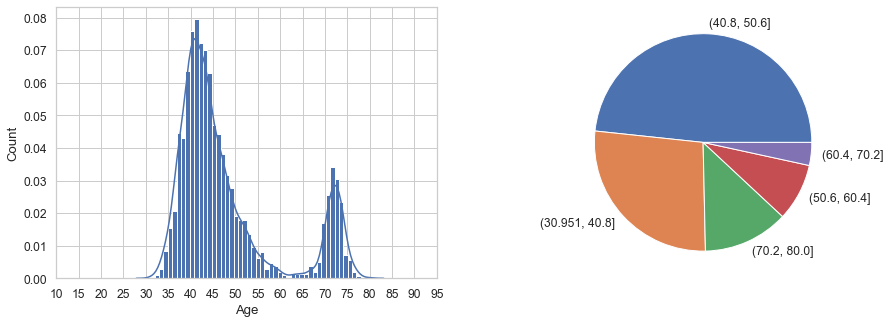

In [1088]:
#univariate analysis : hist and boxplots for numerical , barplot, countplot for categorical
#num_cols = 'Education_Score' and 'Age' are most sensual columns for favourable outcome.
col = 'Age'
data = df_train[df_train[col].notnull()][col]
plt.figure(figsize=((15,5)))

plt.subplot(1,2,1)
sns.set(style='whitegrid', palette="deep", font_scale=1.1)
sns.distplot(data ,kde=True, hist_kws={"alpha": 1}).set( ylabel='Count')
plt.xticks(range(10,100,5))

plt.subplot(1,2,2)
plt.pie(pd.cut(data,5).value_counts(),labels=pd.cut(data,5).value_counts().index)
plt.show()
# we have most of patients from 30-50 and 70-75 age
# it bimodal distribution with 2 set of people 

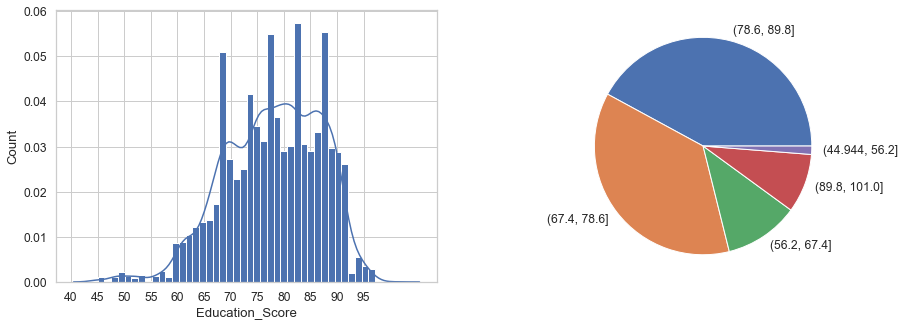

In [1089]:
col = 'Education_Score'
data = df_train[df_train[col].notnull()][col]
plt.figure(figsize=((15,5)))

plt.subplot(1,2,1)
sns.set(style='whitegrid', palette="deep", font_scale=1.1)
sns.distplot(data ,kde=True, hist_kws={"alpha": 1}).set( ylabel='Count')
plt.xticks(range(40,100,5))

plt.subplot(1,2,2)
plt.pie(pd.cut(data,5).value_counts(),labels=pd.cut(data,5).value_counts().index)
plt.show()
# it is multimodal distribution. but as per pie chart we can say most of the patients have 67 - 90 eduction score

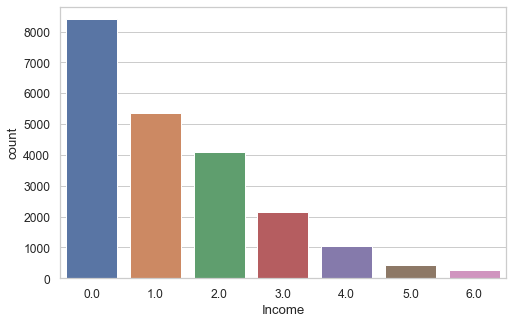

In [1090]:
cat_cols = ['Category1','Category2','Category3','Social_Nw_Presence', 'Income','City_Type','Employer_Category']
col='Income'
plt.figure(figsize=(8,5))
data =  df_train[df_train[col].notnull()][col]
sns.countplot(data)
plt.show()
#most of the patients have income 0


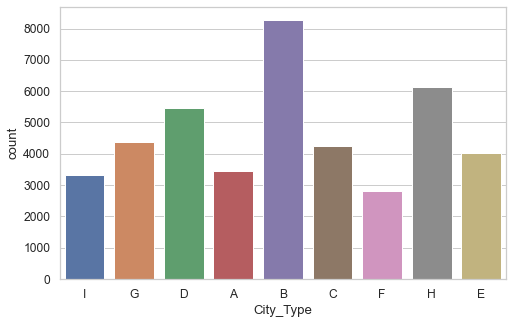

In [1091]:
col='City_Type'
plt.figure(figsize=(8,5))
data = df_train[df_train[col].notnull()][col]
sns.countplot(data)
plt.show()
#most of them are from city type B

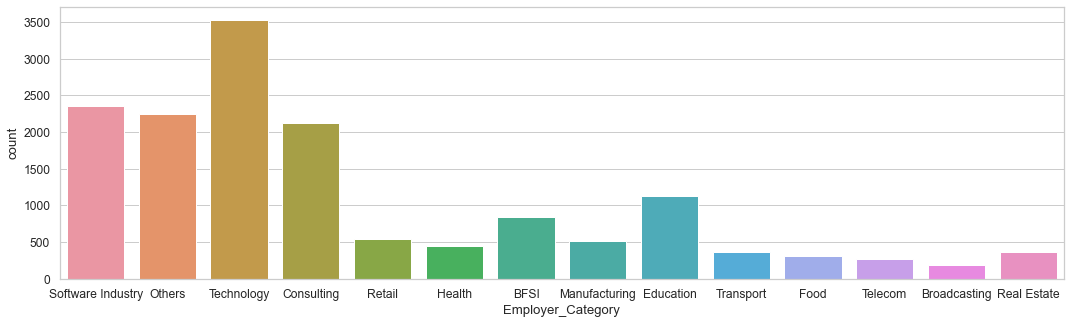

In [1092]:
col='Employer_Category'
plt.figure(figsize=(18,5))
data = df_train[df_train[col].notnull()][col]
sns.countplot(data)
plt.show()
# as expected most of the patients are from technology sector

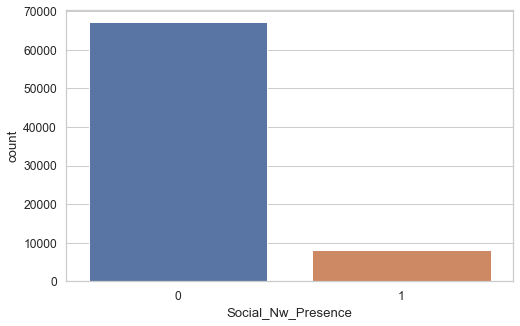

In [1093]:
cat_cols = ['Category1','Category2','Category3','Income','City_Type','Employer_Category','Social_Nw_Presence']
col='Social_Nw_Presence'
data = pd.DataFrame()
plt.figure(figsize=(8,5))
data = df_train[df_train[col].notnull()][col]
sns.countplot(data)
plt.show()
#most of the patients do't have social network presence

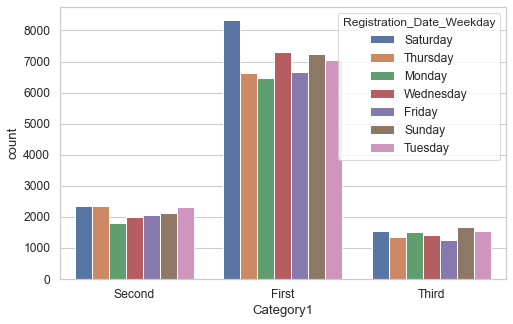

In [1112]:
col='Category1'
data = pd.DataFrame()
plt.figure(figsize=(8,5))
data = df_train[df_train[col].notnull()][col]
sns.countplot(x='Category1',hue='Registration_Date_Weekday',data=df_train )
plt.show()
#most of the patients from First Category

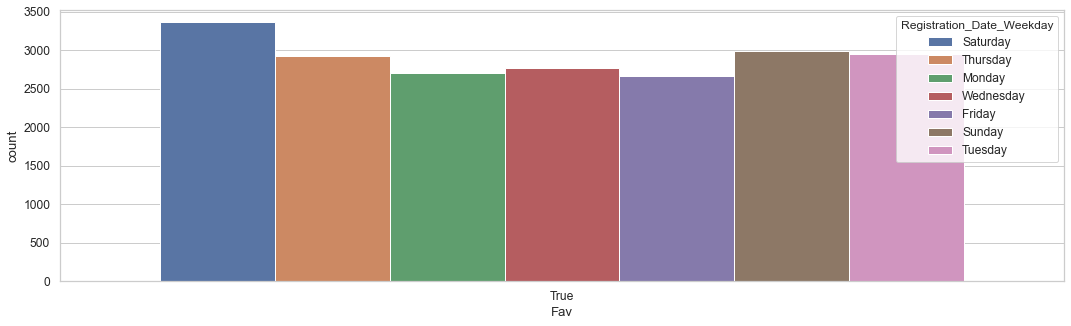

In [1120]:
col='Fav'
data = pd.DataFrame()
plt.figure(figsize=(18,5))
data = df_train[df_train[col].notnull()][col]
sns.countplot(x='Fav',hue='Registration_Date_Weekday',data=df_train[df_train['Fav']==True] )
plt.show()
#we can see more on saturday and sunday

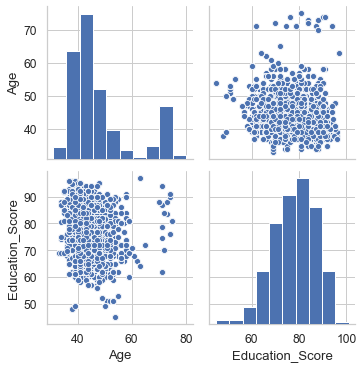

,Age,Education_Score
Age,1.000000,-0.174086
Education_Score,-0.174086,1.000000


In [1096]:
#bivatiate analysis
sns.pairplot(df_train[['Age','Education_Score']])
plt.show()
df_train[['Age','Education_Score']].corr()
#both are -vely correlated

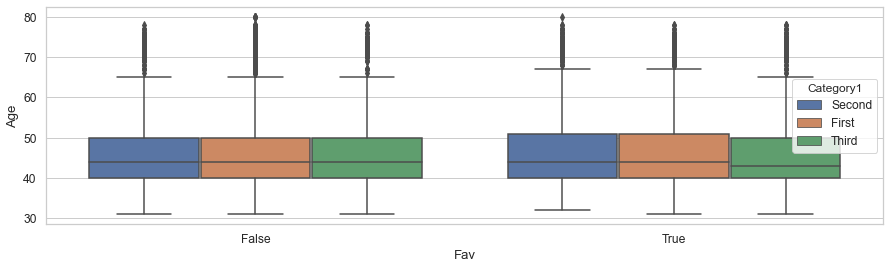

In [1097]:
cat_cols = ['Category1','Category2','Category3','Income','City_Type','Employer_Category','Social_Nw_Presence']
num_cols=['Age','Education_Score']
plt.figure(figsize=(15,4))
sns.boxplot(x='Fav',y='Age',hue='Category1',data=df_train)
#most of the favorable patients are  distributed from 40-50 age and thats more in Third category type.

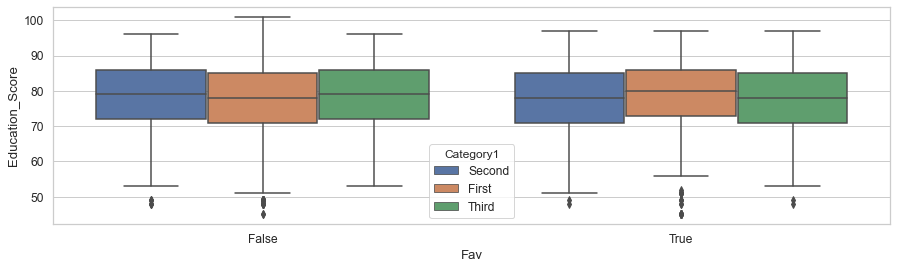

In [1098]:
cat_cols = ['Category1','Category2','Category3','Income','City_Type','Employer_Category','Social_Nw_Presence']
num_cols=['Age','Education_Score']
plt.figure(figsize=(15,4))
sns.boxplot(x='Fav',y='Education_Score',hue='Category1',data=df_train)
#but for eduction score its below median distribution.

In [1153]:
#feature engineering
#handling missing values
x = df_train.isnull().sum() * 100/len(df_train )
x[x>0]
#we still have missing values in huge so drop those columns for now
missing_cols = ['Donation','Income','Education_Score','Age','City_Type','Employer_Category']
df_train.drop(missing_cols,axis=1,inplace=True)
df_train.dropna(subset=['Registration_Date_Month','Registration_Date_Year','Registration_Date_Day',
                        'Registration_Date_Weekday'],axis=0,inplace=True)

In [1155]:
#variable transformations
df_train.describe()

,Health_Camp_ID,Patient_ID,Var1,Var2,Var3,Var4,Var5,Social_Nw_Presence,Category3,Registration_Date_Month,...,Registration_Date_Day,Camp_Start_Date_Month,Camp_Start_Date_Year,Camp_Start_Date_Day,Camp_End_Date_Month,Camp_End_Date_Year,Camp_End_Date_Day,First_Interaction_Month,First_Interaction_Year,First_Interaction_Day
count,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,...,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000
mean,6547.583142,507231.577071,0.783625,0.234975,0.000374,0.022137,0.245317,0.108254,1.994569,6.549464,...,15.697040,6.724141,2004.716055,15.744529,6.769908,2005.294100,13.112284,6.553053,2004.360469,15.603050
std,19.289961,12404.905818,7.571891,3.748142,0.019326,0.198344,1.205674,0.310703,0.073494,3.544424,...,8.944001,3.758003,0.676498,8.812286,3.605961,0.991422,8.062464,3.571371,0.986715,9.022091
min,6523.000000,485679.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,2003.000000,1.000000,1.000000,2003.000000,1.000000,1.000000,2002.000000,1.000000
25%,6534.000000,496502.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,...,8.000000,2.000000,2004.000000,9.000000,2.000000,2005.000000,6.000000,3.000000,2004.000000,8.000000
50%,6541.000000,507276.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,...,16.000000,8.000000,2005.000000,16.000000,7.000000,2005.000000,12.000000,6.000000,2004.000000,15.000000
75%,6562.000000,517919.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,10.000000,...,24.000000,10.000000,2005.000000,23.000000,10.000000,2006.000000,20.000000,10.000000,2005.000000,24.000000
max,6587.000000,528657.000000,288.000000,156.000000,1.000000,4.000000,31.000000,1.000000,2.000000,12.000000,...,31.000000,12.000000,2006.000000,30.000000,12.000000,2007.000000,30.000000,12.000000,2007.000000,31.000000


In [1160]:
df_train['Var5'].value_counts()

0     69073
1      2133
2      1122
3       914
4       546
5       321
6       232
7       199
8       138
9        56
10       54
11       28
14       20
15       15
20       14
16       13
12       12
17       11
22        9
13        8
19        5
29        4
24        4
18        3
21        3
27        3
23        1
25        1
26        1
31        1
Name: Var5, dtype: int64